This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
!pip uninstall lightgbm -y
!pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    n_geographic_split = 48

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
train['latlon_section'] = train[['latitude', 'longitude']].apply(latlon_section, axis = 1)
test['latlon_section'] = test[['latitude', 'longitude']].apply(latlon_section, axis = 1)
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,570
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,422
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,864
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,660
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,546


<BarContainer object of 402 artists>

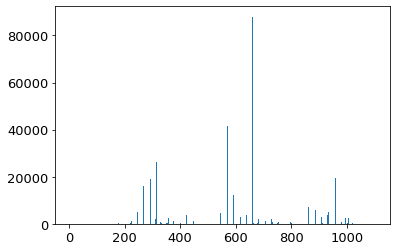

In [ ]:
plt.bar(train['latlon_section'].value_counts().index, train['latlon_section'].value_counts())

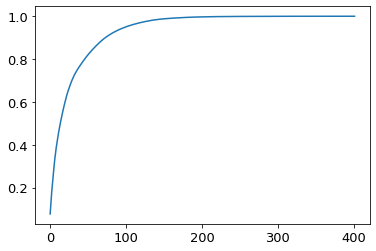

In [ ]:
counts = np.array(train['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("latlon_section")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df[f"d_near_{i}"] = dists[:, i]
            country_df[f"near_target_{i}"] = targets[nears[:, i]]
            for c in columns:
                country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]

        for i in range(min(len(country_df), CFG.n_neighbors), CFG.n_neighbors):
            country_df[f"d_near_{i}"] = np.nan
            country_df[f"near_target_{i}"] = np.nan
            for c in columns:
                country_df[f"near_{c}_{i}"] = np.nan

        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_9,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9
0,E_041e1631792d5e,the mexican,-38.133957,176.251227,nan,rotorua,bay of plenty,nan,nz,nan,...,E_71b4a6130c8dcb,lake rotorua,lake rotorua,rotorua,bay of plenty,3015,nz,nan,nan,lakes


# Create Target

In [ ]:
print(CFG.target)

point_of_interest


In [ ]:
for i in range(CFG.n_neighbors):
    train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9,target
0,E_041e1631792d5e,the mexican,-38.133957,176.251227,nan,rotorua,bay of plenty,nan,nz,nan,...,lake rotorua,lake rotorua,rotorua,bay of plenty,3015,nz,nan,nan,lakes,1.0
1,E_1ed2bcbdbd35d2,whakatane donestic airport,-37.927597,176.929571,aerodrome road,thornton,bay of plenty,3191,nz,nan,...,brew | craft beer pub,1103 tutanekai st,rotorua,bay of plenty,nan,nz,http://brewpub.co.nz,73460976,"bars, pubs, gastropubs",1.0
2,E_20cc9040307e85,oppies takeway,-38.144575,176.253582,cnr fenton st & malfroy rd,rotorua,bay of plenty,nan,nz,nan,...,lake rotorua,lake rotorua,rotorua,bay of plenty,3015,nz,nan,nan,lakes,1.0
3,E_220fd2d490ab85,oppie's fish n' chips,-38.144490,176.253597,259 corner fenton street and malfroy road,rotorua,bay of plenty,nan,nz,nan,...,lake rotorua,lake rotorua,rotorua,bay of plenty,3015,nz,nan,nan,lakes,1.0
4,E_27dd111676fa52,unichem pharmacy,-39.494346,176.914966,munroe st,napier south,hawke's bay,4110,nz,nan,...,overland footwear,156/162 emerson st.,napier,hawke's bay,nan,nz,nan,68359941,shoe stores,0.0


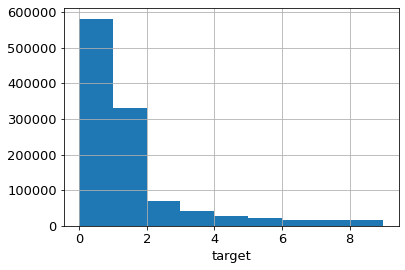

In [ ]:
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
scores = []

train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
    idx = train[CFG.target]==train[f"near_target_{i}"]
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]
    scores.append(get_score(train))
train["mathces"] = None

  0%|          | 0/10 [00:00<?, ?it/s]

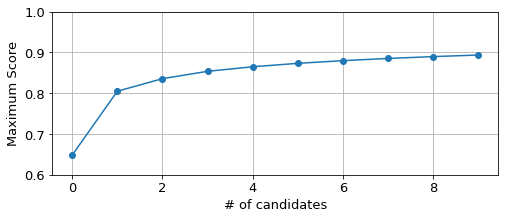

In [ ]:
plt.subplots(figsize=(8, 3), facecolor="white")
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            partial_ratio = []
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                    partial_ratio.append(fuzz.partial_ratio(str1, str2))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
                    partial_ratio.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss
            df[f"near_{c}_{i}_partial_ratio"] = partial_ratio
            
            if not c in ['country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('latlon_section'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train = add_distance_features(train)
test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [ ]:
name_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('svd', TruncatedSVD(n_components=50)),
])
name_pipeline.fit(train["name"].fillna("noname"))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=100000)),
                ('svd', TruncatedSVD(n_components=50))])

In [ ]:
train_name = train["name"].fillna("noname").unique()
train_name_dict = dict(zip(train_name, name_pipeline.transform(train_name)))

In [ ]:
test_name = test["name"].fillna("noname").unique()
test_name_dict = dict(zip(test_name, name_pipeline.transform(test_name)))

In [ ]:
cat_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('svd', TruncatedSVD(n_components=50)),
])
cat_pipeline.fit(train["categories"].fillna("nocategory"))

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=100000)),
                ('svd', TruncatedSVD(n_components=50))])

In [ ]:
train_categories = train["categories"].fillna("nocategory").unique()
train_categories_dict = dict(zip(train_categories, cat_pipeline.transform(train_categories)))

In [ ]:
test_categories = test["categories"].fillna("nocategory").unique()
test_categories_dict = dict(zip(test_categories, cat_pipeline.transform(test_categories)))

In [ ]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
def _add_tfidf_features(args):
    _, df = args

    name = df["name"].fillna("noname").unique()
    name_dict = dict(zip(name, name_pipeline.transform(name)))
    categories = df["categories"].fillna("nocategory").unique()
    categories_dict = dict(zip(categories, cat_pipeline.transform(categories)))
    V = {'name':name_dict, 'categories':categories_dict}

    columns = ['name', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            cos_similarity = []
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                if str1==str1 and str2==str2:
                    try:
                        cos_similarity.append(cos_sim(V[c][str1], V[c][str2]))
                    except:
                        cos_similarity.append(-1)
                else:
                    cos_similarity.append(-1)
            df[f"near_{c}_{i}_cos_sim"] = cos_similarity
    return df


def add_tfidf_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_tfidf_features, df.groupby('latlon_section'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train = add_tfidf_features(train)
test = add_tfidf_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
columns = []
for column in train.columns:
    if "cos_sim" in column:
        columns.append(column)
train[columns]

,near_name_0_cos_sim,near_categories_0_cos_sim,near_name_1_cos_sim,near_categories_1_cos_sim,near_name_2_cos_sim,near_categories_2_cos_sim,near_name_3_cos_sim,near_categories_3_cos_sim,near_name_4_cos_sim,near_categories_4_cos_sim,near_name_5_cos_sim,near_categories_5_cos_sim,near_name_6_cos_sim,near_categories_6_cos_sim,near_name_7_cos_sim,near_categories_7_cos_sim,near_name_8_cos_sim,near_categories_8_cos_sim,near_name_9_cos_sim,near_categories_9_cos_sim
60,1.0,1.0,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
56,1.0,1.0,0.996361,9.967499e-01,0.084540,-5.610841e-04,-0.001489,-5.610841e-04,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
57,1.0,1.0,0.023942,1.000000e+00,0.084540,-5.610841e-04,0.093736,6.895147e-04,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
58,1.0,1.0,0.023942,1.000000e+00,0.084540,-5.610841e-04,0.093736,6.895147e-04,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
59,1.0,1.0,0.996361,9.967499e-01,0.093736,6.895147e-04,0.002970,6.895147e-04,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564438,1.0,1.0,0.281912,-7.714148e-04,0.190990,-1.538450e-03,0.171734,-8.898425e-04,0.203546,-8.898425e-04,-0.000076,9.999814e-01,NaN,-6.714624e-04,NaN,4.169332e-03,NaN,1.476939e-02,NaN,5.805172e-01
564439,1.0,1.0,-0.021338,7.276406e-01,NaN,1.000000e+00,NaN,3.124112e-01,0.269353,-6.652254e-03,0.084675,-1.986028e-01,0.152633,1.000000e+00,-0.224150,6.127779e-04,-0.205552,-6.307225e-02,-0.205552,-6.307225e-02
564440,1.0,1.0,0.506153,-1.491134e-05,0.048721,-2.753267e-03,0.086244,6.021420e-04,0.304331,-2.958996e-03,0.048691,2.352737e-04,0.274227,1.115911e-01,0.279027,-1.729282e-03,0.000702,2.990978e-05,NaN,-5.880818e-05
564441,NaN,1.0,NaN,6.653028e-01,NaN,8.018441e-05,NaN,8.018441e-05,NaN,-1.235497e-03,NaN,-1.960891e-02,NaN,-5.466111e-03,NaN,6.930925e-04,NaN,-1.140082e-10,NaN,-9.153818e-02


# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs", f"near_{c}_{i}_partial_ratio"]
        if c in ['country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]
        if c in ['name', 'categories']:
            features += [f"near_{c}_{i}_cos_sim"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

  0%|          | 0/10 [00:00<?, ?it/s]

['d_near_0', 'near_name_0_gesh', 'near_name_0_jaro', 'near_name_0_lcs', 'near_name_0_partial_ratio', 'near_name_0_len', 'near_name_0_nleven', 'near_name_0_nlcsi', 'near_name_0_nlcs0', 'near_name_0_cos_sim', 'near_address_0_gesh', 'near_address_0_jaro', 'near_address_0_lcs', 'near_address_0_partial_ratio', 'near_address_0_len', 'near_address_0_nleven', 'near_address_0_nlcsi', 'near_address_0_nlcs0', 'near_city_0_gesh', 'near_city_0_jaro', 'near_city_0_lcs', 'near_city_0_partial_ratio', 'near_city_0_len', 'near_city_0_nleven', 'near_city_0_nlcsi', 'near_city_0_nlcs0', 'near_state_0_gesh', 'near_state_0_jaro', 'near_state_0_lcs', 'near_state_0_partial_ratio', 'near_state_0_len', 'near_state_0_nleven', 'near_state_0_nlcsi', 'near_state_0_nlcs0', 'near_zip_0_gesh', 'near_zip_0_jaro', 'near_zip_0_lcs', 'near_zip_0_partial_ratio', 'near_zip_0_leven', 'near_country_0_gesh', 'near_country_0_jaro', 'near_country_0_lcs', 'near_country_0_partial_ratio', 'near_country_0_leven', 'near_url_0_gesh', '

In [ ]:
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Columns: 673 entries, d_near_0 to near_id_9
dtypes: float16(660), float64(1), object(12)
memory usage: 1.5+ GB


# Split Folds

In [ ]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='logloss',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                       params=params, n_class=int(train["target"].max() + 1), 
                       N_SPLITS=CFG.n_splits, folds=train["fold"].values)

# models = [joblib.load(f'../input/foursquare-exp009/lgbm_fold{i}.pkl') for i in range(CFG.n_splits)]
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's multi_logloss: 0.466203
[100]	valid_0's multi_logloss: 0.453881
[150]	valid_0's multi_logloss: 0.448956
[200]	valid_0's multi_logloss: 0.447041
[250]	valid_0's multi_logloss: 0.445912
[300]	valid_0's multi_logloss: 0.445469

== fold 1 ==
[50]	valid_0's multi_logloss: 0.451971
[100]	valid_0's multi_logloss: 0.440098
[150]	valid_0's multi_logloss: 0.436521
[200]	valid_0's multi_logloss: 0.434267
[250]	valid_0's multi_logloss: 0.4332
[300]	valid_0's multi_logloss: 0.432748
[350]	valid_0's multi_logloss: 0.432457

== fold 2 ==
[50]	valid_0's multi_logloss: 0.471357
[100]	valid_0's multi_logloss: 0.460301
[150]	valid_0's multi_logloss: 0.457498
[200]	valid_0's multi_logloss: 0.456629

CV-accuracy: 0.8586263579941202


# Check CV

In [ ]:
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
train["matches"] = matches
print(f"CV: {get_score(train):.6f}")

0it [00:00, ?it/s]

CV: 0.811588


In [ ]:
near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
test["matches"] = matches

0it [00:00, ?it/s]

# Check Feature Importances

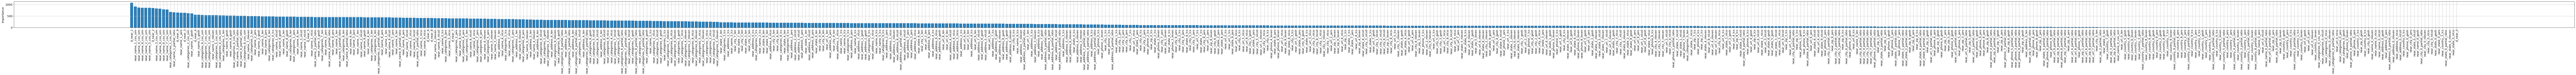

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

train = postprocess(train)
test = postprocess(test)
print(f"CV: {get_score(train):.6f}")

  0%|          | 0/1138812 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

CV: 0.821137


# Submit

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv("submission.csv", index=False)

ssub.head()

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
